# Producto de Estado Hidrológico para cuenca nivel 2
#### Jose Valles (jose.valles.leon@gmail.com)

#### Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('classic')
import numpy as np
import calendar

sns.set()

from IPython.display import HTML

In [5]:
def get_seconds_in_month(row):
    year = int(row['year'])
    month = int(row['month'])
    _, num_days = calendar.monthrange(year, month)
    seconds_in_day = 24 * 60 * 60
    return num_days * seconds_in_day

### Seleccionar cuenca nivel 2

In [120]:
codcuenca_n2 = 65

### Importar datos de modelos

Importar datos de precipitación, escorrentia, humedad suelo y Evapotranspiración (potencial y actual)

In [2]:
# Escorrentia Total
ESCORRENTIA_total = pd.read_csv('../output_modelo/Escorrentia_total.csv')
ESCORRENTIA_total = ESCORRENTIA_total.rename(columns={'-1': 'year','-1.1':'month'})
ESCORRENTIA_total['date'] = pd.to_datetime(dict(year=ESCORRENTIA_total['year'],month=ESCORRENTIA_total['month'],day=1))
ESCORRENTIA_total = ESCORRENTIA_total.set_index('date')
ESCORRENTIA_total['days_in_month'] = ESCORRENTIA_total.index.days_in_month

# Escorrentia Superficial
ESCORRENTIA_sup = pd.read_csv('../output_modelo/Escorrentia_sup.csv')
ESCORRENTIA_sup = ESCORRENTIA_sup.rename(columns={'-1': 'year','-1.1':'month'})
ESCORRENTIA_sup['date'] = pd.to_datetime(dict(year=ESCORRENTIA_sup['year'],month=ESCORRENTIA_sup['month'],day=1))
ESCORRENTIA_sup = ESCORRENTIA_sup.set_index('date')
ESCORRENTIA_sup['days_in_month'] = ESCORRENTIA_sup.index.days_in_month

# Almacenamiento subterraneo
ESCORRENTIA_sub = pd.read_csv('../output_modelo/Escorrentia_sub.csv')
ESCORRENTIA_sub = ESCORRENTIA_sub.rename(columns={'-1': 'year','-1.1':'month'})
ESCORRENTIA_sub['date'] = pd.to_datetime(dict(year=ESCORRENTIA_sub['year'],month=ESCORRENTIA_sub['month'],day=1))
ESCORRENTIA_sub = ESCORRENTIA_sub.set_index('date')
ESCORRENTIA_sub['days_in_month'] = ESCORRENTIA_sub.index.days_in_month

# Precipitación
PRECIP = pd.read_csv('../output_modelo/Pmedias.csv')
PRECIP = PRECIP.rename(columns={'-1': 'year','-1.1':'month'})
PRECIP['date'] = pd.to_datetime(dict(year=PRECIP['year'],month=PRECIP['month'],day=1))

# Evapotranspiración Real
ETR = pd.read_csv('../output_modelo/ETR.csv')
ETR = ETR.rename(columns={'-1': 'year','-1.1':'month'})
ETR['date'] = pd.to_datetime(dict(year=ETR['year'],month=ETR['month'],day=1))

# Humedad Suelo 
SM = pd.read_csv('../output_modelo/HumedadSuelo.csv')
SM = SM.rename(columns={'-1': 'year','-1.1':'month'})
SM['date'] = pd.to_datetime(dict(year=SM['year'],month=SM['month'],day=1))


In [3]:
# Convert 'Year' and 'Month' columns to integers
ESCORRENTIA_total['year'] = ESCORRENTIA_total['year'].astype(int)
ESCORRENTIA_total['month'] = ESCORRENTIA_total['month'].astype(int)

In [6]:
ESCORRENTIA_total['seconds_in_month'] = ESCORRENTIA_total.apply(get_seconds_in_month, axis=1)

Importar codigos de cuenca nivel 2 y 3

In [7]:
CUENCA_NIVEL_3 = pd.read_csv(f'../output_modelo/cuenca_nivel3.csv',index_col="Codigo")
CUENCA_NIVEL_2 = pd.read_csv(f'../output_modelo/cuenca_nivel2.csv',index_col="Codigo")

In [8]:
HTML(ESCORRENTIA_total.tail(6).to_html(index=False))

year,month,101,102,103,105,106,107,108,109,110,111,112,114,115,116,117,119,120,123,125,128,130,131,132,133,134,135,136,137,138,139,140,142,146,148,150,155,158,160,163,165,167,168,170,171,172,173,174,175,176,177,178,179,180,183,186,189,190,193,196,199,201,204,208,210,211,212,213,214,215,216,217,220,221,222,223,224,225,226,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,260,262,264,266,268,270,274,275,276,277,279,280,281,282,283,284,285,286,287,288,289,290,293,294,295,297,298,300,301,305,306,310,312,315,316,318,320,325,330,333,334,335,338,406,407,410,411,412,413,414,415,416,417,418,419,420,422,424,426,428,430,431,432,433,434,435,436,437,438,440,441,442,443,444,445,446,447,448,449,450,452,453,454,455,457,458,459,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,522,524,526,530,532,534,536,538,540,541,542,543,544,545,546,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,575,580,581,582,583,584,585,586,587,588,589,600,601,602,603,604,605,606,607,608,609,610,611,612,613,615,616,618,620,625,630,635,640,645,650,651,652,653,654,655,656,657,658,660,661,662,666,670,673,677,680,683,687,days_in_month,seconds_in_month
2022,12,3.88770,3.89020,2.71840,2.49150,2.04800,2.39700,3.93120,2.53360,2.23180,2.247000,2.303000,2.378000,2.73380,3.01430,2.97750,4.62700,6.32330,6.52480,6.18950,5.78980,4.96420,5.29880,6.281000,6.397000,7.0079,7.31650,7.69270,7.57150,7.13410,7.09920,6.38530,7.07820,7.21560,6.87950,7.09450,7.19250,7.12800,6.77890,6.87280,6.40200,5.81330,4.42790,4.38670,5.2071,1.87810,1.75590,3.9880,3.68460,1.74320,1.58900,2.75350,3.01770,1.421800,1.107900,1.37060,0.053863,0.000953,0.001815,0.000153,1.123200e-04,2.101200e-05,2.853200e-05,2.076200e-05,0.000480,1.076600e-04,3.959000e-05,3.155600e-05,2.629500e-05,3.299900e-05,2.975000e-05,2.098900e-05,2.118100e-05,2.993800e-05,3.271200e-05,4.083100e-05,3.923600e-05,3.905200e-05,3.828300e-05,0.000926,0.000918,0.000827,0.000907,0.000588,0.000449,9.597600e-05,0.000149,3.303400e-05,3.550100e-05,3.366500e-05,6.650400e-05,0.000352,0.000460,0.000266,8.294700e-05,0.000150,0.000146,1.007800e-04,0.087564,0.113720,0.103120,0.083226,0.193500,0.099278,0.623850,0.538240,0.602040,0.482390,0.358180,1.04890,0.819060,0.762750,0.80296,0.87064,0.674810,0.616900,0.712900,0.710470,0.522430,0.519310,0.652330,1.159600,1.39050,2.29340,2.504900,2.556500,2.33400,2.13180,2.694900,2.897600,3.22200,4.15910,4.408500,4.94550,4.973500,5.10970,5.80800,5.83390,5.21800,6.47050,6.88100,4.23340,2.70390,4.44460,4.29210,3.92070,3.68220,3.79750,3.81070,3.8256,3.75120,2.86530,3.11140,2.56140,2.73450,2.76130,3.11650,3.05780,2.04230,2.74660,1.76610,1.55860,1.35940,2.41750,1.71640,2.91430,2.51300,4.93820,2.8631,1.99220,1.59760,1.62300,1.81060,1.90650,2.44400,3.19100,3.34600,4.30670,3.79170,2.83810,3.66660,5.00400,6.6011,6.51410,6.65590,4.188100,4.099200,3.914200,3.893700,4.167500,4.31540,3.93430,3.48450,2.56780,4.355200,4.313400,4.151000,4.40590,4.76180,5.37780,6.33310,5.064100,5.920500,5.737500,6.226700,6.28230,6.186700,6.131500,5.640200,5.954200,5.319800,4.755900,4.050600,3.220500,5.175900,5.15350,3.049200,2.358300,2.630900,3.10620,2.67480,2.89520,2.85010,2.35230,2.450200,2.32050,3.100900,2.247100,2.013600,1.95540,2.18040,1.98100,1.50610,1.18920,0.480810,1.08370,0.054889,0.000935,0.310250,0.000892,0.095518,0.320860,1.12880,0.002872,0.277710,0.459920,2.10230,1.73400,0.126100,0.068388,0.82137,0.028704,0.011638,0.011436,0.007251,1.15180,1.19080,1.11870,0.735300,0.768490,1.11620,0.608100,0.564730,0.370800,0.274560,3.4867,1.22200,0.224290,0.000797,0.351440,0.175640,0.105390,0.000280,0.017021,0.014850,0.004953,1.028500e-04,0.000145,0.001100,0.000903,0.001003,0.001144,0.001093,0.000905,0.000692,0.000222,0.000282,5.606400e-05,6.528800e-05,3.567100e-05,7.209000e-05,0.019159,0.002445,0.056309,1.977900e-05,6.331000e-05,0.038324,31,2678400
2023,1,1.44460,1.44550,1.01010,0.92577,0.76100,0.89067,1.46070,0.94144,0.82929,0.834950,0.855760,0.883610,1.01

### Convertir Escorrentia (mm/month) a Caudal (m3/s)

In [9]:
# Convertir datos de escorrentia a caudal
ESCORRENTIA_SELECTION = ESCORRENTIA_total.drop(['year','month','days_in_month','seconds_in_month'],axis=1)
CAUDAL = pd.DataFrame(ESCORRENTIA_SELECTION.values*1000*CUENCA_NIVEL_3.values,columns=ESCORRENTIA_SELECTION.columns)
CAUDAL['days_in_month'] = ESCORRENTIA_total['days_in_month'].values
CAUDAL = CAUDAL.loc[:, CAUDAL.columns != 'days_in_month'].divide(CAUDAL["days_in_month"]*24*3600, axis="index")
# Definir columns de date y año
CAUDAL['date'] = ESCORRENTIA_total.index.values
CAUDAL = CAUDAL.set_index('date')
CAUDAL['year'] = ESCORRENTIA_total['year'].values
CAUDAL['month'] = ESCORRENTIA_total['month'].values

In [11]:
HTML(CAUDAL.tail(6).to_html(index=True))

,101,102,103,105,106,107,108,109,110,111,112,114,115,116,117,119,120,123,125,128,130,131,132,133,134,135,136,137,138,139,140,142,146,148,150,155,158,160,163,165,167,168,170,171,172,173,174,175,176,177,178,179,180,183,186,189,190,193,196,199,201,204,208,210,211,212,213,214,215,216,217,220,221,222,223,224,225,226,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,260,262,264,266,268,270,274,275,276,277,279,280,281,282,283,284,285,286,287,288,289,290,293,294,295,297,298,300,301,305,306,310,312,315,316,318,320,325,330,333,334,335,338,406,407,410,411,412,413,414,415,416,417,418,419,420,422,424,426,428,430,431,432,433,434,435,436,437,438,440,441,442,443,444,445,446,447,448,449,450,452,453,454,455,457,458,459,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,522,524,526,530,532,534,536,538,540,541,542,543,544,545,546,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,575,580,581,582,583,584,585,586,587,588,589,600,601,602,603,604,605,606,607,608,609,610,611,612,613,615,616,618,620,625,630,635,640,645,650,651,652,653,654,655,656,657,658,660,661,662,666,670,673,677,680,683,687,year,month
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-12-01,1.219261,1.466959,0.825142,0.164649,0.318088,1.320032,3.551935,1.019721,0.049162,0.383393,0.068787,0.214858,0.216385,0.063023,0.332390,2.040206,0.998639,1.154703,1.998924,0.849534,0.411459,1.922952,1.127972,2.992623,1.452130,10.079856,2.148350,2.244538,1.960386,0.691790,0.023840,0.626319,2.877188,0.816787,4.518824,2.019400,2.560161,0.212600,0.369505,0.621461,1.883940,0.593495,2.746601,3.855167,0.243317,0.167828,2.412097,0.884557,0.182234,0.268749,0.813179,0.575734,0.030258,0.239499,1.259351,0.012931,4.625911e-06,0.002112,1.582952e-05,9.770968e-06,7.060484e-08,5.390230e-06,7.805904e-06,1.362830e-05,7.315606e-06,1.463340e-06,1.131039e-06,1.021013e-06,2.427122e-06,2.454730e-06,4.686164e-06,5.535656e-08,2.246691e-06,1.868629e-06,2.789752e-06,2.343847e-07,6.852763e-07,4.545249e-06,2.558421e-05,7.881175e-06,4.662711e-05,3.149549e-05,6.189702e-05,6.441290e-05,2.114167e-06,3.493399e-05,1.332016e-06,6.759823e-07,2.136742e-07,1.315977e-06,5.115646e-05,8.835219e-05,3.533151e-05,3.251731e-06,1.022679e-05,6.114755e-06,4.515233e-06,0.001798,0.002887,0.006353,0.007551,0.061119,0.000741,0.150000,0.013263,0.004720,0.002521,0.004413,0.074798,0.023241,0.046419,0.036574,0.122548,0.039052,0.006219,0.008517,0.016446,0.025747,0.005817,0.018997,0.014720,0.369637,0.011988,0.036474,0.006681,0.754646,0.388410,0.131807,0.027046,0.855302,0.863374,0.064192,2.241576,0.191260,2.623147,0.268889,1.339549,3.767776,0.243997,0.244062,2.958828,0.097923,0.416515,0.410237,0.471351,0.962343,1.288802,0.083942,0.431351,1.107825,0.253538,0.994384,0.019126,0.247069,0.161859,0.657416,0.271713,0.142589,0.190736,0.046157,0.126275,0.357309,0.748248,0.945225,1.558123,0.192341,0.433272,0.487445,0.454463,0.643597,0.970140,2.085462,0.858437,0.986396,0.146540,3.290533,0.418064,0.859305,0.245833,1.384010,1.728159,0.187307,0.014593,0.919460,0.537898,1.692695,0.993749,2.827526,1.513955,1.930201,1.913976,1.602787,2.529068,0.214638,0.193253,0.587376,0.952440,0.627582,0.861364,1.570034,6.740411,0.249782,1.004662,1.731964,1.770884,2.614749,1.973325,0.098973,0.835864,0.826253,5.000229,3.508584,0.349898,1.045461,3.673100,0.753648,0.791559,1.669851,1.244382,1.142462,0.680995,0.012769,0.689425,0.110691,0.224391,2.244865,0.580568,0.312746,0.146743,0.472159,0.359456,0.992483,0.461312,0.086167,0.635233,0.023506,0.000495,0.184060,0.000843,0.059806,0.061215,0.006743,0.003544,0.049665,0.012363,2.161639,0.707610,0.019444,0.006945,0.265571,0.001865,0.003554,0.007549,0.001148,0.115249,0.371680,0.169576,0.011530,0.05222

### Convertir caudal (m3/s) a Volumen (m3)

In [12]:
VOLUME = pd.DataFrame(CAUDAL.drop(['year','month'],axis=1))
VOLUME['seconds_in_month'] = ESCORRENTIA_total['seconds_in_month'].values
VOLUME = VOLUME.loc[:, VOLUME.columns != 'seconds_in_month'].multiply(VOLUME["seconds_in_month"], axis="index")
VOLUME['date'] = CAUDAL.index.values
VOLUME = VOLUME.set_index('date')
VOLUME['year'] = CAUDAL['year'].values
VOLUME['month'] = CAUDAL['month'].values

In [13]:
HTML(VOLUME.tail(6).to_html(index=True))

,101,102,103,105,106,107,108,109,110,111,112,114,115,116,117,119,120,123,125,128,130,131,132,133,134,135,136,137,138,139,140,142,146,148,150,155,158,160,163,165,167,168,170,171,172,173,174,175,176,177,178,179,180,183,186,189,190,193,196,199,201,204,208,210,211,212,213,214,215,216,217,220,221,222,223,224,225,226,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,260,262,264,266,268,270,274,275,276,277,279,280,281,282,283,284,285,286,287,288,289,290,293,294,295,297,298,300,301,305,306,310,312,315,316,318,320,325,330,333,334,335,338,406,407,410,411,412,413,414,415,416,417,418,419,420,422,424,426,428,430,431,432,433,434,435,436,437,438,440,441,442,443,444,445,446,447,448,449,450,452,453,454,455,457,458,459,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,522,524,526,530,532,534,536,538,540,541,542,543,544,545,546,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,575,580,581,582,583,584,585,586,587,588,589,600,601,602,603,604,605,606,607,608,609,610,611,612,613,615,616,618,620,625,630,635,640,645,650,651,652,653,654,655,656,657,658,660,661,662,666,670,673,677,680,683,687,year,month
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-12-01,3265668.0,3929102.0,2210059.20,440995.50,851968.00,3535575.00,9513504.0,2731220.80,131676.20,1026879.000,184240.00,575476.000,579565.60,168800.80,890272.50,5464487.00,2674755.90,3092755.20,5353917.5,2275391.40,1102052.40,5150433.60,3021161.000,8015441.000,3889384.5,26997885.0,5754139.60,6011771.00,5250697.60,1852891.20,63853.0,1677533.40,7706260.80,2187681.0,12103217.00,5408760.00,6857136.00,569427.60,989683.20,1664520.0,5045944.40,1589616.10,7356495.90,10325679.3,651700.70,449510.40,6460560.0,2369197.80,488096.0,719817.00,2178018.50,1542044.70,81042.600,641474.100,3373046.60,34633.9090,12.390040,5657.922800,42.397780,26.170560,0.189108,14.437192,20.907334,36.502040,19.594120,3.919410,3.029376,2.734680,6.500803,6.574750,12.551422,0.148267,6.017538,5.004936,7.472073,0.627776,1.835444,12.173994,68.524740,21.108940,124.886060,84.357510,165.784980,172.523520,5.662584,93.567210,3.567672,1.810551,0.572305,3.524712,137.017470,236.642500,94.631920,8.709435,27.391440,16.377760,12.093600,4816.02000,7732.96000,17014.80000,20223.91800,163701.0000,1985.5600,401759.400,35523.840,12642.8400,6753.4600,11819.9400,200339.90,62248.5600,124328.2500,97961.12,328231.28,104595.550,16656.3000,22812.800,44049.1400,68960.7600,15579.300,50881.7400,39426.400,990036.00,32107.60,97691.100,17895.500,2021244.00,1040318.40,353031.900,72440.000,2290842.00,2312459.6,171931.500,6003837.00,512270.500,7025837.50,720192.00,3587848.50,10091612.0,653520.50,653695.00,7924924.80,262278.30,1115594.60,1098777.60,1262465.40,2577540.0,3451927.50,224831.30,1155331.2,2967199.20,679076.10,2663358.40,51228.0,661749.0,433524.10,1760822.50,727756.40,381910.10,510867.60,123627.0,338216.20,957017.60,2004107.50,2531690.00,4173277.60,515165.00,1160477.00,1305573.6,1217234.20,1723810.40,2598423.00,5585701.00,2299239.00,2641964.00,392493.00,8813364.00,1119742.0,2301561.90,658439.2,3706932.60,4628700.00,501683.6,39084.60,2462683.0,1440706.400,4533715.200,2661656.00,7573246.500,4054977.500,5169849.20,5126392.90,4292904.00,6773856.40,574886.40,517608.00,1573229.000,2551016.10,1680915.40,2307076.20,4205178.40,1.805352e+07,669016.500,2690887.500,4638891.50,4743136.50,7003344.400,5285353.000,265089.400,2238779.200,2213036.800,1.339261e+07,9397392.00,937165.500,2800161.900,9838031.50,2018570.400,2120111.700,4472530.0,3332952.60,3059971.20,1823976.0,34201.20,1846555.5,296474.200,601009.50,6012645.100,1554993.200,837657.600,393035.40,1264632.0,962766.00,2658266.50,1235578.80,230788.8,1701409.0,6.295768e+04,1.3255

## Normales hidrologicas para cuencas nivel 2

Seleccionar la variable de escorrentia que se desee analizar (Escorrentia Total, Escorrentia superficial o almacenamiento subterraneo)

In [44]:
# Seleccionar Escorrentia
ESCORRENTIA = ESCORRENTIA_total

Filtrar las series en base al codigo cuenca nivel 2 seleccionada (codcuenca_n2)

In [14]:
# Buscar columnas que empiezan con el codigo de cuenca nivel 2
filter_col = [col for col in CAUDAL if col.startswith(str(codcuenca_n2))]

# Obtener variables en base a los codigos de cuenca nivel 3 que corresponden a las cuencas nivel 2
CAUDAL_SELECTED = CAUDAL[filter_col]
PRECIP_SELECTED = PRECIP[filter_col]
ETR_SELECTED = ETR[filter_col]
SM_SELECTED = SM[filter_col]
ESCORRENTIA_SELECTED = ESCORRENTIA[filter_col]
VOLUME_SELECTED = VOLUME[filter_col]

Si se tiene seleccionada la cuenca 61, se puede obtener el volumen que llegaria a Paso Severino removiendo la subcuenca nivel 3 que no aporta. Para lo anterior, descomentar el codigo de abajo

In [15]:
#VOLUME_SELECTED = VOLUME_SELECTED.drop(columns=['618']) # Remove the subbasin below Paso Severino IF the basin_nivel_2 = 61
# HTML(VOLUME_SELECTED.tail(6).to_html(index=False))

### Agregar las variables para las cuencas nivel 2 seleccionada

In [16]:
# Caudal
CAUDAL_N2 = pd.DataFrame()
CAUDAL_N2['year'] = CAUDAL['year']
CAUDAL_N2['month'] = CAUDAL['month']
CAUDAL_N2['discharge'] = CAUDAL_SELECTED.sum(axis=1)

CAUDAL_N2['date'] = pd.to_datetime(dict(year=CAUDAL_N2['year'],month=CAUDAL_N2['month'],day=1))
CAUDAL_N2 = CAUDAL_N2.set_index('date')

# Precip
PRECIP_N2 = pd.DataFrame()
PRECIP_N2['year'] = PRECIP['year']
PRECIP_N2['month'] = PRECIP['month']
PRECIP_N2['precip'] = PRECIP_SELECTED.mean(axis=1)

PRECIP_N2['date'] = pd.to_datetime(dict(year=PRECIP_N2['year'],month=PRECIP_N2['month'],day=1))
PRECIP_N2 = PRECIP_N2.set_index('date')

# Escorrentia
ESCORRENTIA_N2 = pd.DataFrame()
ESCORRENTIA_N2['year'] = ESCORRENTIA['year']
ESCORRENTIA_N2['month'] = ESCORRENTIA['month']
ESCORRENTIA_N2['runoff'] = ESCORRENTIA_SELECTED.mean(axis=1)

ESCORRENTIA_N2['date'] = pd.to_datetime(dict(year=ESCORRENTIA_N2['year'],month=ESCORRENTIA_N2['month'],day=1))
ESCORRENTIA_N2 = ESCORRENTIA_N2.set_index('date')

# ETR
ETR_N2 = pd.DataFrame()
ETR_N2['year'] = ETR['year']
ETR_N2['month'] = ETR['month']
ETR_N2['etr'] = ETR_SELECTED.mean(axis=1)

ETR_N2['date'] = pd.to_datetime(dict(year=ETR_N2['year'],month=ETR_N2['month'],day=1))
ETR_N2 = ETR_N2.set_index('date')

# Humedad Suelo
SM_N2 = pd.DataFrame()
SM_N2['year'] = SM['year']
SM_N2['month'] = SM['month']
SM_N2['soilmoisture'] = SM_SELECTED.mean(axis=1)

SM_N2['date'] = pd.to_datetime(dict(year=SM_N2['year'],month=SM_N2['month'],day=1))
SM_N2 = SM_N2.set_index('date')

# Volumen (Aqui se convierte el volumen de m3 a hm3)
VOLUME_N2 = pd.DataFrame()
VOLUME_N2['year'] = VOLUME['year']
VOLUME_N2['month'] = VOLUME['month']
VOLUME_N2['volume'] = VOLUME_SELECTED.sum(axis=1) / 1e6

VOLUME_N2['date'] = pd.to_datetime(dict(year=VOLUME_N2['year'],month=VOLUME_N2['month'],day=1))
VOLUME_N2 = VOLUME_N2.set_index('date')

Se muestra la serie temporal de la variable nivel 2 que se seleccione. 

*Nota: El volumen fue convertido de m3 a hm3 en el paso anterior*

In [18]:
HTML(VOLUME_N2.tail(10).to_html(index=True))

,year,month,volume
date,,,
2022-08-01,2022,8,0.154967
2022-09-01,2022,9,0.057582
2022-10-01,2022,10,0.021396
2022-11-01,2022,11,0.007950
2022-12-01,2022,12,0.002954
2023-01-01,2023,1,0.001098
2023-02-01,2023,2,0.000408
2023-03-01,2023,3,1.301742
2023-04-01,2023,4,1.200839


In [15]:
# SM_N2.to_clipboard()

*Guardar la variable agregada a nivel 2 a archivo csv*

In [35]:
# Quitar comentario si desea graficar el caudal 
# CAUDAL_N2_PLOT = CAUDAL_N2

# Graficar los ultimos valores 
VOLUME_N2_PLOT = VOLUME_N2.tail(12)

# Quitar comentario si desea un periodo mas largo
# VOLUME_N2_PLOT = VOLUME_N2.loc['2022-01-01':'2024-05-01']

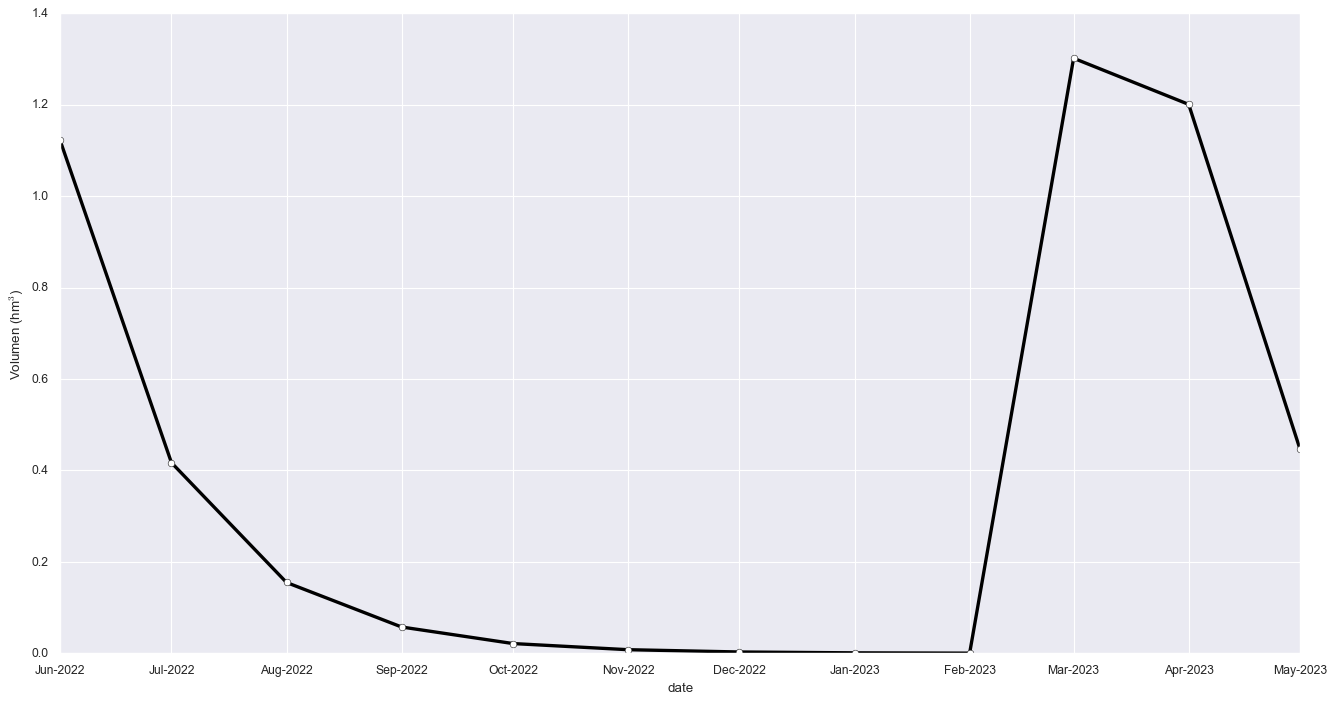

In [45]:
import matplotlib.dates as mdates

fig1, ax1 = plt.subplots(figsize=(20, 10))
ax1.plot(VOLUME_N2_PLOT.index,VOLUME_N2_PLOT['volume'],linestyle = '-', color = 'black',linewidth=3, marker='o', mfc='white', mec='k')

# ax1 = VOLUME_N2_PLOT['volume'].plot(figsize=(20, 10),color='black',linestyle='-', linewidth=3, marker='o', mfc='white', mec='k');
ax1.set_xlabel('date');
# ax1.set_ylabel('Caudal (m$^3$/s)');
ax1.set_ylabel('Volumen (hm$^3$)');

ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))   #to get a tick every 1 month
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
# ax1.set_ylim(0,50)
plt.xticks(rotation=0);   #optional formatting 

In [154]:
# VOLUME_N2_PLOT.to_clipboard()

### Seleccionar el periodo de simulación para calcular las normales

En esta parte utilizaremos el periodo 1981-2010

In [37]:
year_start = 1981
year_end = 2010
# Caudal
CAUDAL_N2_REF = CAUDAL_N2[(CAUDAL_N2['year'] >= year_start) & (CAUDAL_N2['year'] <= year_end)]

# Escorrentia
ESCORRENTIA_N2_REF = ESCORRENTIA_N2[(ESCORRENTIA_N2['year'] >= year_start) & (ESCORRENTIA_N2['year'] <= year_end)]

# Precip
PRECIP_N2_REF = PRECIP_N2[(PRECIP_N2['year'] >= year_start) & (PRECIP_N2['year'] <= year_end)]

# ETR
ETR_N2_REF = ETR_N2[(ETR_N2['year'] >= year_start) & (ETR_N2['year'] <= year_end)]

# Humedad Suelo
SM_N2_REF = SM_N2[(SM_N2['year'] >= year_start) & (SM_N2['year'] <= year_end)]

# Volumen
VOLUME_N2_REF = VOLUME_N2[(VOLUME_N2['year'] >= year_start) & (VOLUME_N2['year'] <= year_end)]

Calcular las normales correspondiente al periodo de referencia

In [38]:
# Caudal
CAUDAL_N2_AVERAGE = CAUDAL_N2_REF.groupby(CAUDAL_N2_REF.month).mean()
CAUDAL_N2_AVERAGE = CAUDAL_N2_AVERAGE.reindex(columns=['discharge'])

# Escorrentia
ESCORRENTIA_N2_AVERAGE = ESCORRENTIA_N2_REF.groupby(ESCORRENTIA_N2_REF.month).mean()
ESCORRENTIA_N2_AVERAGE = ESCORRENTIA_N2_AVERAGE.reindex(columns=['runoff'])

# Precip
PRECIP_N2_AVERAGE = PRECIP_N2_REF.groupby(PRECIP_N2_REF.month).mean()
PRECIP_N2_AVERAGE = PRECIP_N2_AVERAGE.reindex(columns=['precip'])

# ETR
ETR_N2_AVERAGE = ETR_N2_REF.groupby(ETR_N2_REF.month).mean()
ETR_N2_AVERAGE = ETR_N2_AVERAGE.reindex(columns=['etr'])

# Humedad Suelo
SM_N2_AVERAGE = SM_N2_REF.groupby(SM_N2_REF.month).mean()
SM_N2_AVERAGE = SM_N2_AVERAGE.reindex(columns=['soilmoisture'])

# Volumen
VOLUME_N2_AVERAGE = VOLUME_N2_REF.groupby(VOLUME_N2_REF.month).mean()
VOLUME_N2_AVERAGE = VOLUME_N2_AVERAGE.reindex(columns=['volume'])


In [39]:
HTML(CAUDAL_N2_AVERAGE.to_html())

,discharge
month,
1,13.457639
2,21.540972
3,36.204189
4,26.894447
5,45.344561
6,51.835812
7,54.122978
8,51.860373
9,46.407790


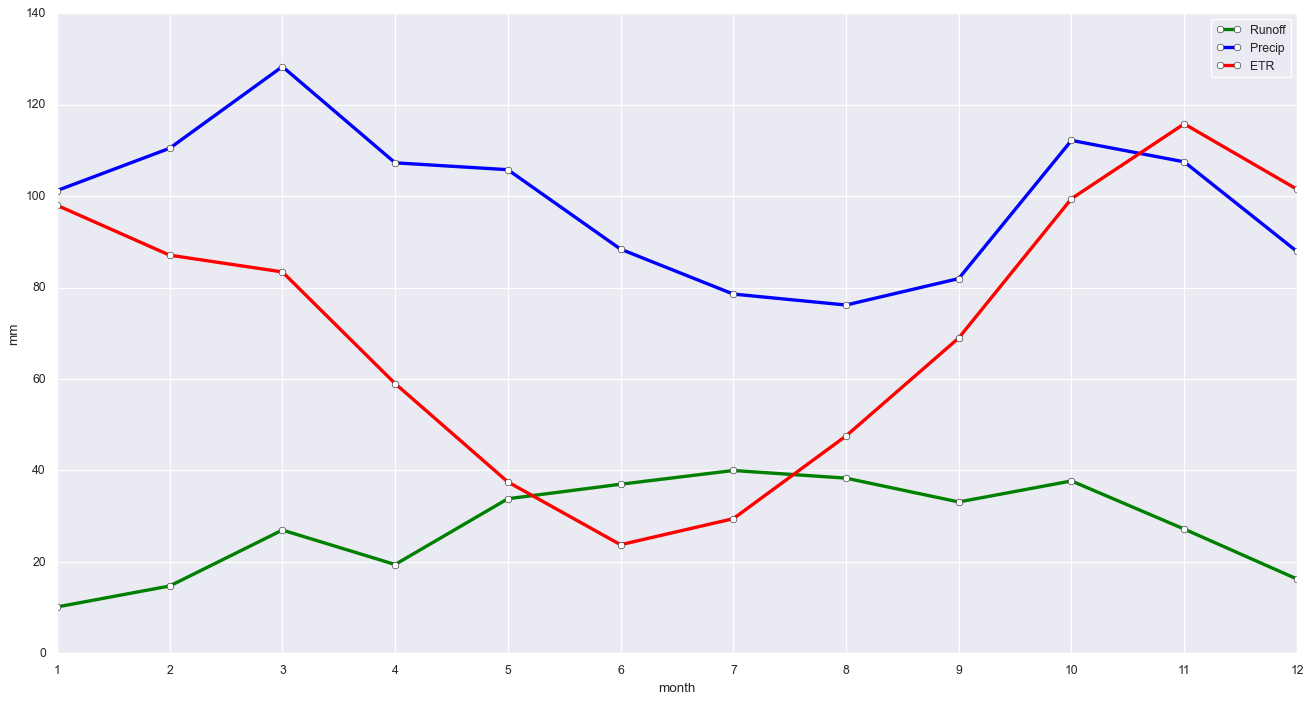

In [40]:
ax2 = ESCORRENTIA_N2_AVERAGE['runoff'].plot(figsize=(20, 10),color='green',linestyle='-', linewidth=3, marker='o', mfc='white', mec='k',label='Runoff');
ax2 = PRECIP_N2_AVERAGE['precip'].plot(figsize=(20, 10),color='blue',linestyle='-', linewidth=3, marker='o', mfc='white', mec='k',label='Precip');
ax2 = ETR_N2_AVERAGE['etr'].plot(figsize=(20, 10),color='red',linestyle='-', linewidth=3, marker='o', mfc='white', mec='k',label='ETR');
ax2.set_xlim(1,12)
ax2.set_xlabel('month');
ax2.set_ylabel('mm');
ax2.set_xticks(np.arange(1,13,1));
ax2.legend();

In [41]:
# ESCORRENTIA_N2_AVERAGE.to_clipboard()

In [42]:
variable_basin = [PRECIP_N2.precip, ETR_N2.etr, SM_N2.soilmoisture, ESCORRENTIA_N2.runoff, CAUDAL_N2.discharge, VOLUME_N2.volume]
variable_basin = pd.concat(variable_basin,axis=1)

In [43]:
HTML(variable_basin.tail(12).to_html(index=True))

,precip,etr,soilmoisture,runoff,discharge,volume
date,,,,,,
2022-06-01,0.748016,18.214333,35.764556,0.310006,0.433016,1.122378
2022-07-01,84.383222,23.904000,96.243889,0.115192,0.155709,0.417052
2022-08-01,33.227556,41.670222,87.802111,0.042803,0.057858,0.154967
2022-09-01,18.608689,68.768000,37.641878,0.015904,0.022215,0.057582
2022-10-01,49.914778,86.339889,1.217111,0.005910,0.007988,0.021396
2022-11-01,63.033667,64.250778,0.000000,0.002196,0.003067,0.007950
2022-12-01,38.983111,38.983111,0.000000,0.000816,0.001103,0.002954
2023-01-01,13.898111,13.898111,0.000000,0.000303,0.000410,0.001098
2023-02-01,43.468000,43.468000,0.000000,0.000113,0.000169,0.000408


In [46]:
# variable_basin.to_clipboard()

### Seleccionar variable para calcular percentil 


En este punto se debe seleccionar la variable n2 y su respectiva variable normal para que se calcule el percentil mensual

In [85]:
VARIABLE_MENSUAL = VOLUME_N2
VARIABLE_AVERAGE = VOLUME_N2_AVERAGE
VARIABLE_REF = VOLUME_N2_REF
VARIABLE = VARIABLE_MENSUAL.columns[2]
print(VARIABLE)

volume


In [48]:
# create empty columns in the dataframe
VARIABLE_MENSUAL['mean'] = np.nan
VARIABLE_MENSUAL['average_percentage'] = np.nan
VARIABLE_MENSUAL['rank_average'] = np.nan
VARIABLE_MENSUAL['non_missing'] = np.nan


for i in range(len(VARIABLE_MENSUAL)):
    # Extract the current month 
    m = VARIABLE_MENSUAL.month[i]
    # Extract the current year
    y = VARIABLE_MENSUAL.year[i]
    VARIABLE_MENSUAL.loc[VARIABLE_MENSUAL.eval('month==@m & year==@y'),'rank_average']  = VARIABLE_MENSUAL.query('month==@m')[VARIABLE].rank()
    VARIABLE_MENSUAL.loc[VARIABLE_MENSUAL.eval('month==@m & year==@y'),'non_missing']  = VARIABLE_MENSUAL.query('month==@m')[VARIABLE].notnull().sum()
    VARIABLE_MENSUAL.loc[VARIABLE_MENSUAL.eval('month==@m & year==@y'),'mean'] = VARIABLE_AVERAGE.query('month == @m')[VARIABLE].item()
    VARIABLE_MENSUAL.loc[VARIABLE_MENSUAL.eval('month==@m & year==@y'),'average_percentage'] = (VARIABLE_MENSUAL[VARIABLE][i] - VARIABLE_AVERAGE.query('month == @m')[VARIABLE].item()) / VARIABLE_AVERAGE.query('month == @m')[VARIABLE].item()
    
    

In [49]:
VARIABLE_MENSUAL.tail(8)

,year,month,volume,mean,average_percentage,rank_average,non_missing
date,,,,,,,
2022-10-01,2022,10,0.021396,136.429049,-0.999843,1.0,43.0
2022-11-01,2022,11,0.007950,97.090233,-0.999918,1.0,43.0
2022-12-01,2022,12,0.002954,58.825662,-0.999950,1.0,43.0
2023-01-01,2023,1,0.001098,36.044941,-0.999970,1.0,44.0
2023-02-01,2023,2,0.000408,52.913543,-0.999992,1.0,44.0
2023-03-01,2023,3,1.301742,96.969301,-0.986576,10.0,44.0
2023-04-01,2023,4,1.200839,69.710407,-0.982774,9.0,44.0
2023-05-01,2023,5,0.446206,121.450873,-0.996326,7.0,44.0


### Calcular el percentil utilizando la formula de Weibull

Calcular el percentil usando esta formula

$$
\ percentile = \frac{i}{N+1}
$$ 


donde _i_ es en rank del mes actual y _N_ es el número de meses en el periodo de registro  

In [50]:
VARIABLE_MENSUAL['percentile'] = VARIABLE_MENSUAL['rank_average']/(VARIABLE_MENSUAL['non_missing']+1)

### Asignar para cada percentil un rango

| Category | Percentile Range |
| :- | :-: |
| High flow | 0.870000 - 1.000000 |
| Above normal | 0.720000 - 0.869999 |
| Normal range | 0.280000 - 0.719999 |
| Below normal | 0.130000 - 0.279999 |
| Low flow | 0.000000 - 0.129999 |

In [51]:
# CRITERIO # 1

criteria = [VARIABLE_MENSUAL['percentile'].between(0.87,1.00),
            VARIABLE_MENSUAL['percentile'].between(0.72,0.87),
            VARIABLE_MENSUAL['percentile'].between(0.28,0.72),
            VARIABLE_MENSUAL['percentile'].between(0.13,0.28),
            VARIABLE_MENSUAL['percentile'].between(0.00,0.13)]

values = ['High flow','Above normal','Normal range','Below normal','Low flow']

# CRITERIO # 2

# criteria = [VARIABLE_MENSUAL['percentile'].between(0.95,1.00),
#             VARIABLE_MENSUAL['percentile'].between(0.87,0.95),
#             VARIABLE_MENSUAL['percentile'].between(0.72,0.87),
#             VARIABLE_MENSUAL['percentile'].between(0.28,0.72),
#             VARIABLE_MENSUAL['percentile'].between(0.13,0.28),
#             VARIABLE_MENSUAL['percentile'].between(0.05,0.13),
#             VARIABLE_MENSUAL['percentile'].between(0.00,0.05)]

# values = ['Exceptionally high flow','Notably high flow','Above normal','Normal range','Below normal','Notably low flow','Exceptionally low flow']

VARIABLE_MENSUAL['percentile_range'] = np.select(criteria,values,None)

In [52]:
HTML(VARIABLE_MENSUAL.tail(12).to_html())

,year,month,volume,mean,average_percentage,rank_average,non_missing,percentile,percentile_range
date,,,,,,,,,
2022-06-01,2022,6,1.122378,134.358424,-0.991646,8.0,43.0,0.181818,Below normal
2022-07-01,2022,7,0.417052,144.962983,-0.997123,6.0,43.0,0.136364,Below normal
2022-08-01,2022,8,0.154967,138.902824,-0.998884,1.0,43.0,0.022727,Low flow
2022-09-01,2022,9,0.057582,120.288992,-0.999521,1.0,43.0,0.022727,Low flow
2022-10-01,2022,10,0.021396,136.429049,-0.999843,1.0,43.0,0.022727,Low flow
2022-11-01,2022,11,0.007950,97.090233,-0.999918,1.0,43.0,0.022727,Low flow
2022-12-01,2022,12,0.002954,58.825662,-0.999950,1.0,43.0,0.022727,Low flow
2023-01-01,2023,1,0.001098,36.044941,-0.999970,1.0,44.0,0.022222,Low flow
2023-02-01,2023,2,0.000408,52.913543,-0.999992,1.0,44.0,0.022222,Low flow


In [53]:
# VARIABLE_MENSUAL.to_clipboard()

In [121]:
# Quitar comentario si desea graficar toda la serie
# VARIABLE_MENSUAL_PLOT = VARIABLE_MENSUAL

# Graficar los ultimos valores 
VARIABLE_MENSUAL_PLOT = VARIABLE_MENSUAL.tail(56)

# Quitar comentario si desea un periodo mas largo
# VARIABLE_MENSUAL_PLOT = VARIABLE_MENSUAL.loc['2022-04-01':'2023-11-01']

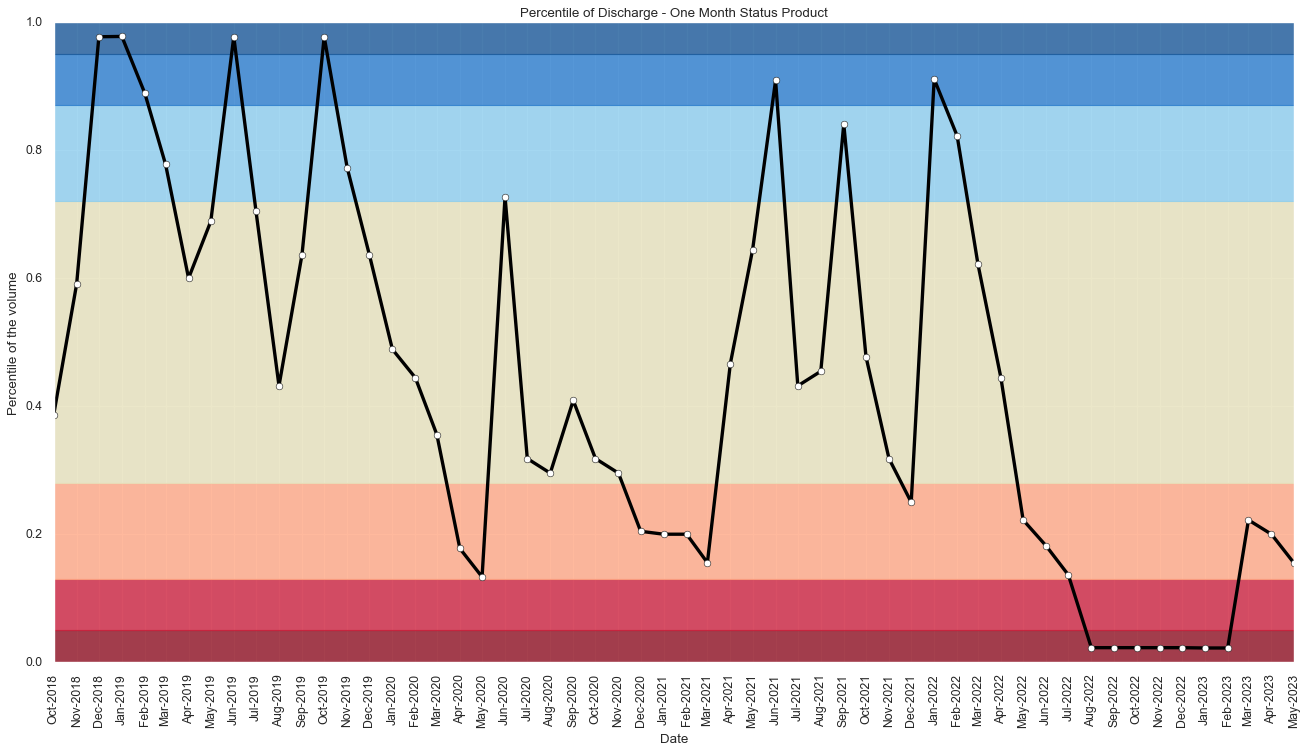

In [122]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(VARIABLE_MENSUAL_PLOT.index,VARIABLE_MENSUAL_PLOT['percentile'],linestyle = '-', color = 'black',linewidth=3, marker='o', mfc='white', mec='k')

ax.axhspan(0.0, 0.05, color='#901222',alpha=0.8)
ax.axhspan(0.05, 0.13, color='#CD233F',alpha=0.8)
ax.axhspan(0.13, 0.28, color='#FFA885',alpha=0.8)
ax.axhspan(0.28, 0.72, color='#E7E2BC',alpha=0.8)
ax.axhspan(0.72, 0.87, color='#8ECEEE',alpha=0.8)
ax.axhspan(0.87, 0.95, color='#2C7DCD',alpha=0.8)
ax.axhspan(0.95, 1.00, color='#1d5b9a',alpha=0.8)
ax.set_xlim([VARIABLE_MENSUAL_PLOT.index[0],VARIABLE_MENSUAL_PLOT.index[-1]])
ax.set_ylim([0, 1])
ax.set_xlabel('Date')
ax.set_ylabel(f'Percentile of the {VARIABLE}')
ax.set_title('Percentile of Discharge - One Month Status Product');

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))   #to get a tick every 1 month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
# ax1.set_ylim(0,50)
plt.xticks(rotation=90);   #optional formatting 

## Producto de estado hidrológico a una escala de 3 meses

In [63]:
# from monthly to 3 months
VARIABLE_THREE_MONTHS = pd.DataFrame(VARIABLE_MENSUAL[VARIABLE].rolling(3).apply(lambda x: x.mean() if x.isnull().sum()*100/len(x) < 50 else np.nan))

In [64]:
VARIABLE_THREE_MONTHS['startMonth'] = (VARIABLE_THREE_MONTHS.index - pd.DateOffset(months=2)).month
VARIABLE_THREE_MONTHS['endMonth'] = VARIABLE_THREE_MONTHS.index.month
VARIABLE_THREE_MONTHS['year'] = VARIABLE_THREE_MONTHS.index.year
VARIABLE_THREE_MONTHS.index = VARIABLE_THREE_MONTHS.index.map(lambda t: t.replace(day=1))

In [66]:
HTML(VARIABLE_THREE_MONTHS.tail(12).to_html(index=True))

,volume,startMonth,endMonth,year
date,,,,
2022-06-01,4.090736,4,6,2022
2022-07-01,1.520010,5,7,2022
2022-08-01,0.564799,6,8,2022
2022-09-01,0.209867,7,9,2022
2022-10-01,0.077982,8,10,2022
2022-11-01,0.028976,9,11,2022
2022-12-01,0.010767,10,12,2022
2023-01-01,0.004001,11,1,2023
2023-02-01,0.001487,12,2,2023


In [67]:
VARIABLE_SELECTION_THREE_MONTH = VARIABLE_THREE_MONTHS[(VARIABLE_THREE_MONTHS['year'] >= 1981) & (VARIABLE_THREE_MONTHS['year'] < 2010)]

In [71]:
VARIABLE_AVERAGE_THREE_MONTH = VARIABLE_SELECTION_THREE_MONTH.groupby(VARIABLE_SELECTION_THREE_MONTH.startMonth).mean()
VARIABLE_AVERAGE_THREE_MONTH = VARIABLE_AVERAGE_THREE_MONTH.reindex(columns=[VARIABLE])

In [72]:
HTML(VARIABLE_AVERAGE_THREE_MONTH.to_html())

,volume
startMonth,
1,55.862623
2,69.498085
3,97.779677
4,110.856898
5,134.461640
6,137.746795
7,131.076553
8,129.909063
9,117.983076


In [75]:
VARIABLE_THREE_MONTHS['average_percentage'] = np.nan
VARIABLE_THREE_MONTHS['rank_average'] = np.nan
VARIABLE_THREE_MONTHS['non_missing'] = np.nan

for i in range(len(VARIABLE_THREE_MONTHS)):
    # Extract the current month 
    m = VARIABLE_THREE_MONTHS.startMonth[i]
    # Extract the current year
    y = VARIABLE_THREE_MONTHS.year[i]
    VARIABLE_THREE_MONTHS.loc[VARIABLE_THREE_MONTHS.eval('startMonth==@m & year==@y'),'rank_average']  = VARIABLE_THREE_MONTHS.query('startMonth==@m')[VARIABLE].rank()
    VARIABLE_THREE_MONTHS.loc[VARIABLE_THREE_MONTHS.eval('startMonth==@m & year==@y'),'non_missing']  = VARIABLE_THREE_MONTHS.query('startMonth==@m')[VARIABLE].notnull().sum()
    VARIABLE_THREE_MONTHS.loc[VARIABLE_THREE_MONTHS.eval('startMonth==@m & year==@y'),'average_percentage'] = (VARIABLE_THREE_MONTHS[VARIABLE][i] - VARIABLE_AVERAGE_THREE_MONTH.query('startMonth == @m')[VARIABLE].item()) / VARIABLE_AVERAGE_THREE_MONTH.query('startMonth == @m')[VARIABLE].item()
    

In [77]:
HTML(VARIABLE_THREE_MONTHS.tail(6).to_html())

,volume,startMonth,endMonth,year,average_percentage,rank_average,non_missing
date,,,,,,,
2022-12-01,0.010767,10,12,2022,-0.999892,1.0,43.0
2023-01-01,0.004001,11,1,2023,-0.999931,1.0,43.0
2023-02-01,0.001487,12,2,2023,-0.999964,1.0,43.0
2023-03-01,0.434416,1,3,2023,-0.992223,2.0,44.0
2023-04-01,0.834329,2,4,2023,-0.987995,3.0,44.0
2023-05-01,0.982929,3,5,2023,-0.989948,5.0,44.0


In [78]:
VARIABLE_THREE_MONTHS['percentile'] = VARIABLE_THREE_MONTHS['rank_average']/(VARIABLE_THREE_MONTHS['non_missing']+1)

In [79]:
criteria_three_months = [VARIABLE_THREE_MONTHS['percentile'].between(0.87,1.00),
            VARIABLE_THREE_MONTHS['percentile'].between(0.72,0.87),
            VARIABLE_THREE_MONTHS['percentile'].between(0.28,0.72),
            VARIABLE_THREE_MONTHS['percentile'].between(0.13,0.28),
            VARIABLE_THREE_MONTHS['percentile'].between(0.00,0.13)]

values_three_months = ['High flow','Above normal','Normal range','Below normal','Low flow']

VARIABLE_THREE_MONTHS['percentile_range'] = np.select(criteria_three_months,values_three_months,None)

In [80]:
row_labels = {1:'JFM',
             2:'FMA',
             3:'MAM',
             4:'AMJ',
             5:'MJJ',
             6:'JJA',
             7:'JAS',
             8:'ASO',
             9:'SON',
             10:'OND',
             11:'NDE',
             12:'DEF'}
VARIABLE_THREE_MONTHS['period'] = VARIABLE_THREE_MONTHS['startMonth'].replace(row_labels) 

In [81]:
HTML(VARIABLE_THREE_MONTHS.tail(7).to_html())

,volume,startMonth,endMonth,year,average_percentage,rank_average,non_missing,percentile,percentile_range,period
date,,,,,,,,,,
2022-11-01,0.028976,9,11,2022,-0.999754,1.0,43.0,0.022727,Low flow,SON
2022-12-01,0.010767,10,12,2022,-0.999892,1.0,43.0,0.022727,Low flow,OND
2023-01-01,0.004001,11,1,2023,-0.999931,1.0,43.0,0.022727,Low flow,NDE
2023-02-01,0.001487,12,2,2023,-0.999964,1.0,43.0,0.022727,Low flow,DEF
2023-03-01,0.434416,1,3,2023,-0.992223,2.0,44.0,0.044444,Low flow,JFM
2023-04-01,0.834329,2,4,2023,-0.987995,3.0,44.0,0.066667,Low flow,FMA
2023-05-01,0.982929,3,5,2023,-0.989948,5.0,44.0,0.111111,Low flow,MAM


In [82]:
# Quitar comentario si desea graficar toda la serie
# VARIABLE_TRIMENSUAL_PLOT = VARIABLE_THREE_MONTHS

# Graficar los ultimos valores 
VARIABLE_TRIMENSUAL_PLOT = VARIABLE_THREE_MONTHS.tail(48)

# Quitar comentario si desea un periodo mas largo
# VARIABLE_TRIMENSUAL_PLOT = VARIABLE_THREE_MONTHS.loc['2022-04-01':'2023-11-01']

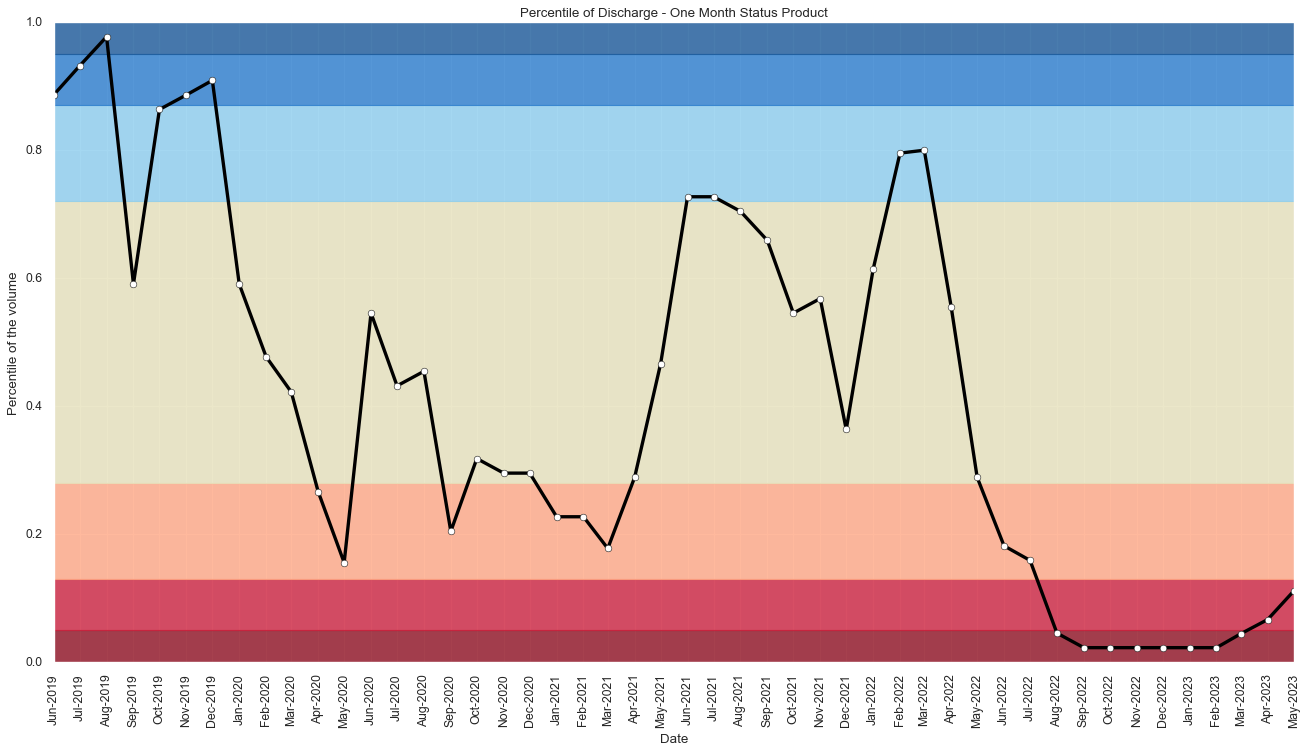

In [83]:
fig2, ax2 = plt.subplots(figsize=(20, 10))
ax2.plot(VARIABLE_TRIMENSUAL_PLOT.index,VARIABLE_TRIMENSUAL_PLOT['percentile'],linestyle = '-', color = 'black',linewidth=3, marker='o', mfc='white', mec='k')

ax2.axhspan(0.0, 0.05, color='#901222',alpha=0.8)
ax2.axhspan(0.05, 0.13, color='#CD233F',alpha=0.8)
ax2.axhspan(0.13, 0.28, color='#FFA885',alpha=0.8)
ax2.axhspan(0.28, 0.72, color='#E7E2BC',alpha=0.8)
ax2.axhspan(0.72, 0.87, color='#8ECEEE',alpha=0.8)
ax2.axhspan(0.87, 0.95, color='#2C7DCD',alpha=0.8)
ax2.axhspan(0.95, 1.00, color='#1d5b9a',alpha=0.8)
ax2.set_xlim([VARIABLE_TRIMENSUAL_PLOT.index[0],VARIABLE_TRIMENSUAL_PLOT.index[-1]])
ax2.set_ylim([0, 1])
ax2.set_xlabel('Date')
ax2.set_ylabel(f'Percentile of the {VARIABLE}')
ax2.set_title('Percentile of Discharge - One Month Status Product');

ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=1))   #to get a tick every 1 month
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
# ax1.set_ylim(0,50)
plt.xticks(rotation=90);   #optional formatting 

## Producto de series temporales con fondo de percentiles


In [84]:
# OJO: CAMBIAR LA FECHA
variable_plot = VARIABLE_MENSUAL.loc['2022-05-01':'2023-11-01']
variable_plot = variable_plot.reset_index()

In [99]:
percentiles = VARIABLE_REF.groupby(VARIABLE_REF.month).quantile([0.13,0.28,0.72,0.87])
percentiles = percentiles.reset_index()
percentiles = percentiles.drop(columns=['year'])
percentiles.rename(columns={'level_1':'percentile',VARIABLE:f'{VARIABLE}_percentile'}, inplace=True)

In [100]:
percentiles['date'] = pd.to_datetime(percentiles['month'],format='%m',errors='coerce')
percentiles['date'] = percentiles['date'].dt.to_period('M').dt.to_timestamp()

In [101]:
# create empty columns in the dataframe
variable_plot['13th_percentile'] = np.nan
variable_plot['28th_percentile'] = np.nan
variable_plot['72th_percentile'] = np.nan
variable_plot['87th_percentile'] = np.nan

for i in range(len(variable_plot)):
    # Extract the current month 
    m = variable_plot.month[i]
    variable_plot.loc[variable_plot.eval('month==@m'),'minimum']  = percentiles.query('month==@m & percentile==0.13')[f'{VARIABLE}_percentile'].item()
    variable_plot.loc[variable_plot.eval('month==@m'),'13th_percentile']  = percentiles.query('month==@m & percentile==0.13')[f'{VARIABLE}_percentile'].item()
    variable_plot.loc[variable_plot.eval('month==@m'),'28th_percentile']  = percentiles.query('month==@m & percentile==0.28')[f'{VARIABLE}_percentile'].item()
    variable_plot.loc[variable_plot.eval('month==@m'),'72th_percentile']  = percentiles.query('month==@m & percentile==0.72')[f'{VARIABLE}_percentile'].item()
    variable_plot.loc[variable_plot.eval('month==@m'),'87th_percentile']  = percentiles.query('month==@m & percentile==0.87')[f'{VARIABLE}_percentile'].item()

In [103]:
df_stats = pd.DataFrame(index=pd.date_range(start=variable_plot['date'].iloc[0], end=variable_plot['date'].iloc[-1], freq='MS',inclusive='both'))
df_stats['month'] = df_stats.index.month
df_stats = df_stats.rename_axis('date')

In [104]:
# create empty columns in the dataframe
df_stats['13th_percentile'] = np.nan
df_stats['28th_percentile'] = np.nan
df_stats['72th_percentile'] = np.nan
df_stats['87th_percentile'] = np.nan

for i in range(len(df_stats)):
    # Extract the current month 
    m = df_stats.month[i]
    df_stats.loc[df_stats.eval('month==@m'),'13th_percentile']  = percentiles.query('month==@m & percentile==0.13')[f'{VARIABLE}_percentile'].item()
    df_stats.loc[df_stats.eval('month==@m'),'28th_percentile']  = percentiles.query('month==@m & percentile==0.28')[f'{VARIABLE}_percentile'].item()
    df_stats.loc[df_stats.eval('month==@m'),'72th_percentile']  = percentiles.query('month==@m & percentile==0.72')[f'{VARIABLE}_percentile'].item()
    df_stats.loc[df_stats.eval('month==@m'),'87th_percentile']  = percentiles.query('month==@m & percentile==0.87')[f'{VARIABLE}_percentile'].item()

df_stats = df_stats.reset_index()
# df_stats['date'] = df_stats['date'].dt.strftime('%Y-%m-01')

In [118]:
import datetime

last_month = variable_plot['date'].loc[0]
# last_month = datetime.date(2023,5,1)

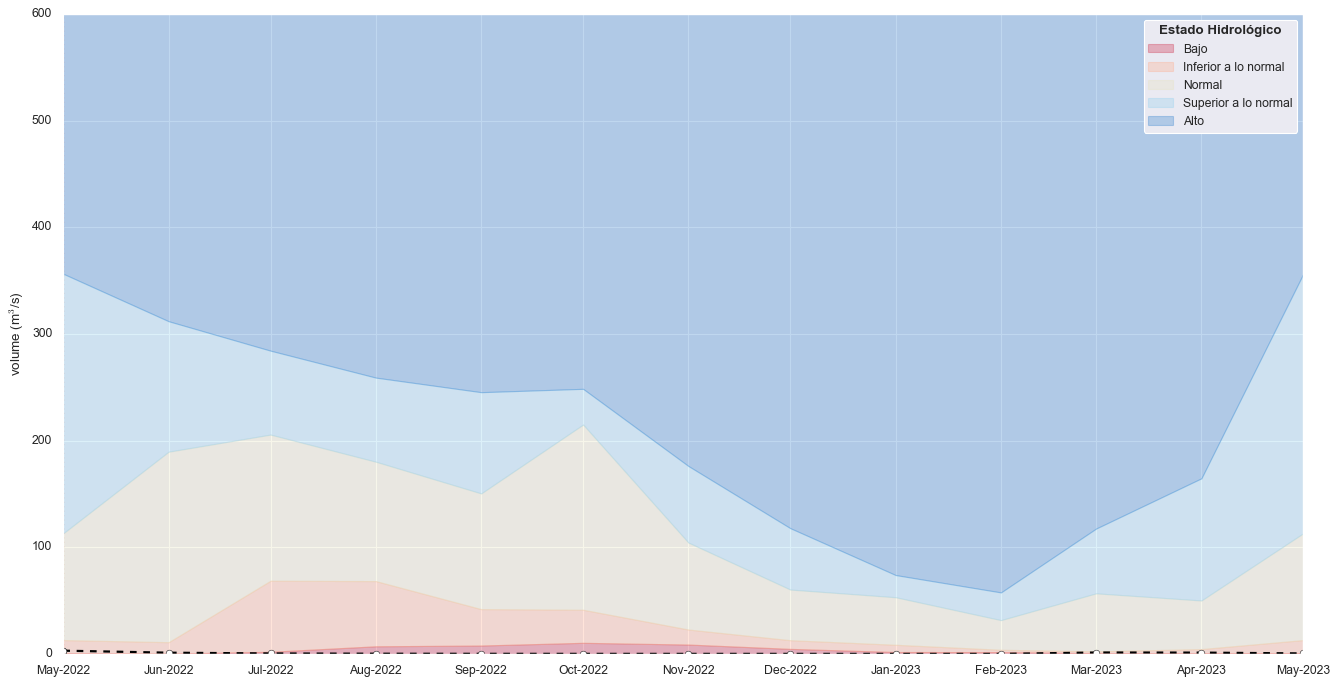

In [119]:
fig3, ax3 = plt.subplots(figsize=(20, 10))

y1 = variable_plot.loc[variable_plot.date <= last_month.strftime('%Y-%m-%d')]
y2 = variable_plot.loc[variable_plot.date >= last_month.strftime('%Y-%m-%d')]

ax3.plot(y1['date'],y1[VARIABLE],color = 'black',linestyle = '-',linewidth=2,marker='o', mfc='white', mec='k', label='_nolegend_');
ax3.plot(y2['date'],y2[VARIABLE],color = 'black',linestyle = '--',linewidth=2,marker='o', mfc='white', mec='k', label='_nolegend_');

# ax3.plot(discharge_plot['date'],discharge_plot['discharge'],color = 'black',linewidth=2,marker='o', mfc='white', mec='k', label='_nolegend_');
ax2.set_xlabel('Date');
## To add labels get unique dates, sort them, convert to format you like and plot
# ax2.set_xticklabels(pd.concat([discharge_plot.date, pd.Series(concat_df.date.unique())]).sort_values().reset_index(drop=True).dt.strftime('%b/%Y'), rotation=90 )
ax3.fill_between(df_stats['date'], 0, df_stats['13th_percentile'], color='#CD233F', alpha=0.3,label="Bajo")
ax3.fill_between(df_stats['date'], df_stats['13th_percentile'], df_stats['28th_percentile'], color='#FFA885', alpha=0.3,label="Inferior a lo normal")
ax3.fill_between(df_stats['date'], df_stats['28th_percentile'], df_stats['72th_percentile'], color='#E7E2BC', alpha=0.3,label="Normal")
ax3.fill_between(df_stats['date'], df_stats['72th_percentile'], df_stats['87th_percentile'], color='#8ECEEE', alpha=0.3,label="Superior a lo normal")
ax3.fill_between(df_stats['date'], df_stats['87th_percentile'], 600,color='#2C7DCD', alpha=0.3,label="Alto")
# ax3.set_ylim(0,200)
ax3.legend(loc='best',title='Estado Hidrológico',fancybox=True, title_fontproperties={'weight':'bold'})
ax3.set_ylabel(f'{VARIABLE} (m$^3$/s)');

ax3.axvline(x = last_month, color = 'r',label = 'now', linestyle=':', linewidth=2, mfc='white', mec='k');

ax3.xaxis.set_major_locator(mdates.MonthLocator(interval=1))   #to get a tick every 1 month
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))   #optional formatting 
plt.xticks(rotation=0);